In [1]:
import pandas as pd
import numpy as np
import malariagen_data
import allel

In [13]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns

sns.set_context('paper')
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.dpi'] = 150 
sns.set_context('paper', font_scale=.6)

In [3]:
#define some data points 

In [14]:
## Let's acces to the data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

# Let's locate the 
pos, ref, alt = ag3.snp_sites(contig="X", site_mask="gamb_colu")
pos = allel.SortedIndex(pos)

# The AGAP000080 gene is located in the X chromosomes in the region ranging from 1283016 to 1373662
loc_region  = pos.locate_range(1283016,1373662)

# Fru region
fru_region = ('X', 1283016, 1373655)

## reference genome
df_geneset = ag3.geneset().set_index("ID")
#df_geneset

## let's access to the reference transcript of the gene AGAP000080
df_geneset.query("Parent == 'AGAP000080'")

## let's choose a transcripts
transcrit_id = 'AGAP000080-RA', 'AGAP000080-RB', 'AGAP000080-RC', 'AGAP000080-RD', 'AGAP000080-RE'
#transcrit_id

fru_genset = df_geneset.loc[(df_geneset.index == 'AGAP000080')|
                           (df_geneset.index.isin(transcrit_id))|
                           (df_geneset.Parent.isin(transcrit_id))]
gene_id = list(fru_genset.index)
fru_genset.insert(8, 'gene_id', gene_id)
fru_genset = fru_genset.fillna(0) 

# Import conservation score data 
C_score = pd.read_table('/home/mkient/AgamP4_conservation_score/Results/results_Cs.tsv') # Check the data source if it doesn't work
#C_score.head()

In [6]:
### Functions 

/tmp/ipykernel_4313/4239502804.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


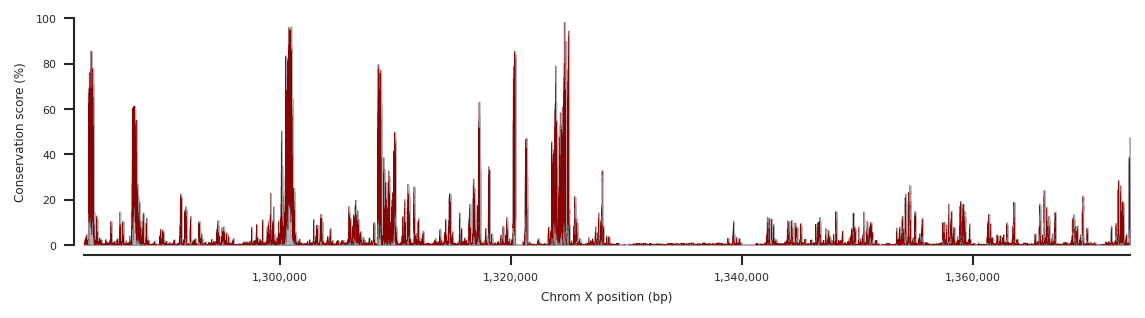

In [22]:
def plot_Cs(loc=fru_region, ylim=(0, 100), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 2))
        sns.despine(ax=ax, offset=5)
    
    # plot cs
    pl = C_score.query(f'pos > {loc[1]} and pos < {loc[2]}')
    ax.fill_between(pl.pos, 0, pl.Cs * 100, color='k', alpha=.3)
    ax.plot(pl.pos, pl.Cs * 100 , linestyle='-', linewidth = 0.1, marker=None, color='darkred')
    ax.set_ylabel('Conservation score (%)')
    ax.set_xlabel(f'Chrom {loc[0]} position (bp)')
    # tidy up
    xlim = (loc[1], loc[2])
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
    
plot_Cs()

In [21]:
## Function to compute transcript dataframe by transcripts
def transcript_dataset(data, transcript):
    'This function compute the dataset of each transcript'
    for idx in data.index:
        if idx == transcript:
            val = data.index.get_loc(idx)
            transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
    return transcript_data

In [41]:
def plot_transcripts(geneset, height=.5, label_transcripts=True, label_exons=False, label_exon_size=False,
                     label_codons=False, highlight_exons=None, label_cdss=False, highlight_color='red', ax=None,
                     title=None, xlim=None, exon_label='{}', include_transcripts=None):
    """Plot all transcripts for one or all genes overlapping a given region."""

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 1))
    sns.despine(ax=ax, left=True, bottom=True)
        
    if title:
        ax.set_title(title, va='bottom')

    # find genes overlapping the given region 
    genes = geneset.query("(type == 'gene')").sort_values('start')

    # iterate over genes
    for _, gene in genes.iterrows():

        # find child transcripts
        transcripts = geneset.query("(type == 'mRNA') and (Parent == %r)" % gene.gene_id).sort_values('gene_id')

        # iterate over transcripts
        for i, (_, transcript) in enumerate(transcripts.iterrows()):
            if include_transcripts is not None and transcript.gene_id not in include_transcripts:
                continue
            
            # coordinates for plotting the transcript
            if transcript.strand == '+':
                y = i
            else:
                y = -i - 1

            # annotate with transcript ID
            if xlim is not None:
                start, stop = xlim
                text_y = y + height + (height / 10)
                if label_transcripts == 'right':
                    text_x = min(stop, transcript.end)
                    ha = 'right'
                else:
                    text_x = max(start, transcript.start)
                    ha = 'left'
                if label_transcripts:
                    if transcript.strand == '+':
                        text = '%s >' % transcript.gene_id
                    else:
                        text = '< %s' % transcript.gene_id
                    ax.text(text_x, text_y, text, ha=ha, va='bottom')
            
            # find child exons
            exons = geneset.query("type == 'exon' and Parent == %r" % transcript.gene_id).sort_values('start')
            
            # iterate over exons to plot introns
            last_exon = None
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x

                # plot intron
                if last_exon is not None:
                    ax.plot([last_exon.end, (last_exon.end + exon.start) / 2, exon.start], [y + height / 2, y + height / 1.5, y + height / 2], 'gray')
                last_exon = exon
                
                # exon number
                n = i + 1 if exon.strand == '+' else len(exons) - i

            # find child CDSs
            cdss = geneset.query("type == 'CDS' and Parent == %r" % transcript.gene_id)
            if transcript.strand == '+':
                cdss = cdss.sort_values('start', ascending=True)
            else:
                cdss = cdss.sort_values('end', ascending=False)
                
            # keep track of CDS position
            cds_pos = 0
            
            # plot CDSs
            for _, cds in cdss.iterrows():
                x = cds.start
                width = cds.end - x
                
                # plot CDS
                patch = plt.Rectangle((x, y), width, height, color='darkgray')
                ax.add_patch(patch)
                
                # accumulate CDS positions
                cds_pos += width + 1  

            # find child UTRs
            utrs = geneset.query("(type == 'three_prime_UTR' or type == 'five_prime_UTR') and Parent == %r" % transcript.gene_id).sort_values('start')
            for _, utr in utrs.iterrows():
                x = utr.start
                width = utr.end - x
                utr_height = height#* .8
                utr_y = y + (height - utr_height) / 2
                patch = plt.Rectangle((x, utr_y), width, utr_height, color='darkred')
                ax.add_patch(patch)

            # plot exons
            if transcript.strand == '+':
                exons = exons.sort_values('start', ascending=True)
            else:
                exons = exons.sort_values('end', ascending=False)
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x
                exon_height = height#* .8
                exon_y = y + (height - exon_height) / 2
                patch = plt.Rectangle((x, exon_y), width, exon_height, facecolor='none', edgecolor='k', linewidth=0.01)
                ax.add_patch(patch)

                # label exons
                if label_exons == transcript.gene_id and xlim is not None:
#                     text_y = y - height/10
                    text_y = y + height/2
                    start, stop = xlim
                    if exon.end > start and exon.start < stop:
                        if exon.start < start:
                            text_x = (start + exon.end) / 2
                        elif exon.end > stop:
                            text_x = (exon.start + stop) / 2
                        else:
                            text_x = (exon.start + exon.end) / 2
                        s = exon_label.format(i + 1)
                        ax.text(text_x, text_y, s, ha='center', va='center', color='k', zorder=20)

    ax.set_yticks([])
    if xlim:
        ax.set_xlim(*xlim)
        ax.set_xticks([])
        ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])
        ax.autoscale(axis='y', tight=False)

/tmp/ipykernel_4313/4239502804.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


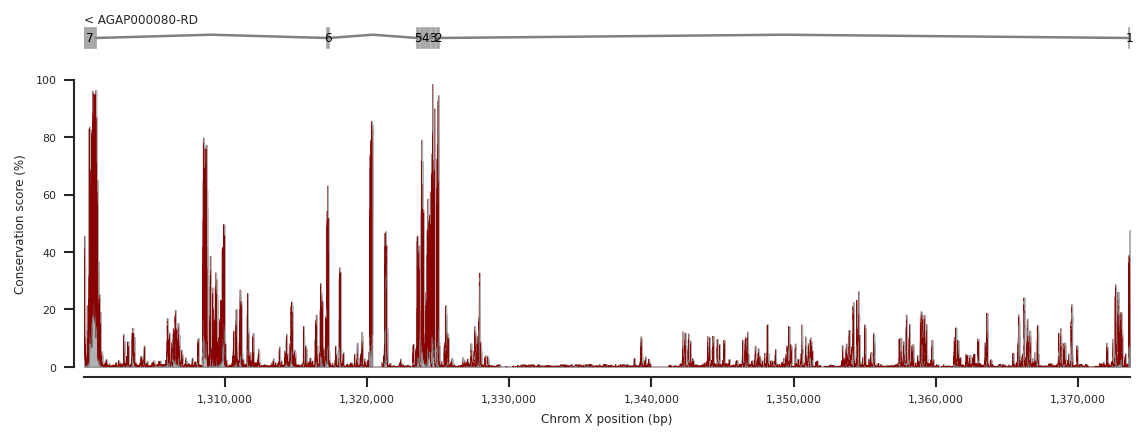

In [57]:
def Cs_fig(data = fru_RD, xlim = RD_reg, ylim=(0, 4), window_size=100, window_step=None,
                                figsize=(9, 3), exon_label='{}'):
    gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(.15, 2))
    
    fig = plt.figure(figsize=figsize)
    
    # plot the gene model
    ax = fig.add_subplot(gs[0])
    plot_transcripts(data, ax=ax, xlim=xlim[1:], label_exons=f'{data.index[1]}', exon_label=exon_label)
    ax.set_xlim(*xlim[1:])
    
    # plot diversity
    ax = fig.add_subplot(gs[1])
    plot_Cs(loc = xlim, ax = ax)
    sns.despine(ax=ax, offset=5)
    ax.set_xlim(*xlim[1:])

Cs_fig()

In [56]:
fru_RA.index[1]

'AGAP000080-RA'

/tmp/ipykernel_4313/4239502804.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


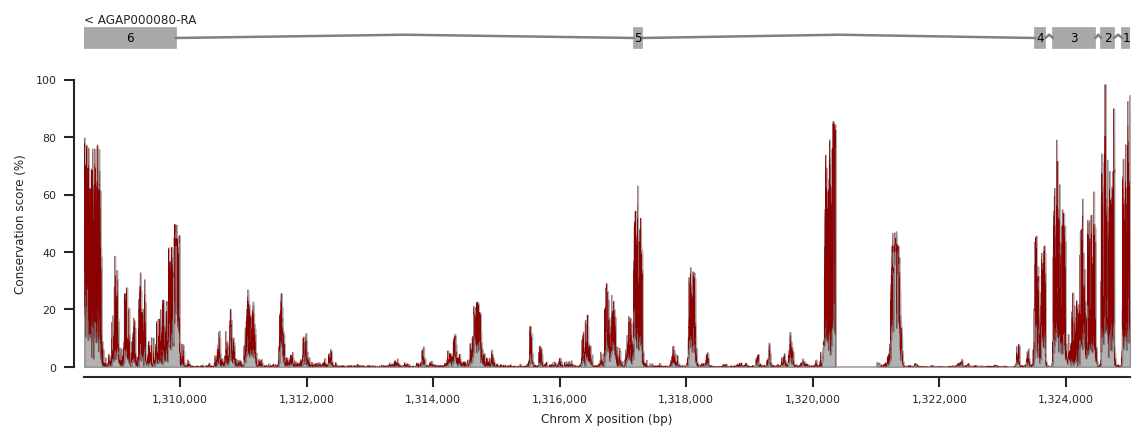

In [58]:
## Conservation score within the transcrit AGAP000080-RA
RA_reg = ('X', 1308485, 1325015)
fru_RA = transcript_dataset(fru_genset, 'AGAP000080-RA')
Cs_fig(data=fru_RA, xlim=RA_reg)

/tmp/ipykernel_4313/4239502804.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


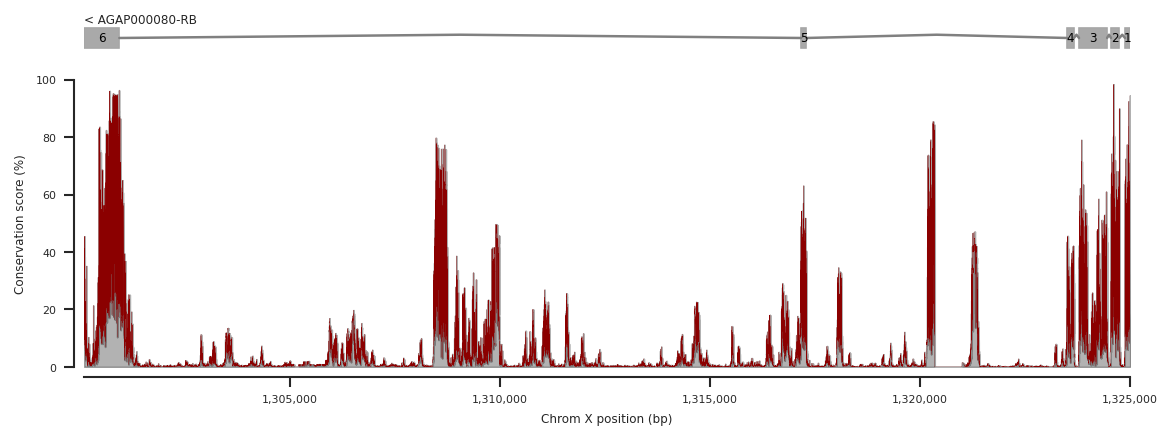

In [59]:
## Conservation score within the transcrit AGAP000080-RB
RB_reg = ('X', 1300109, 1325015)
fru_RB = transcript_dataset(fru_genset, 'AGAP000080-RB')
Cs_fig(data=fru_RB, xlim=RB_reg)

/tmp/ipykernel_4313/4239502804.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


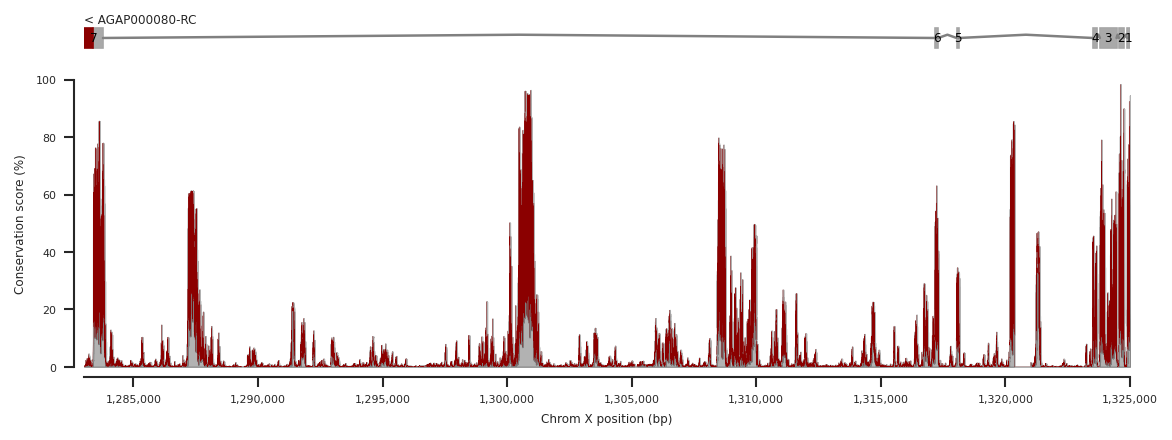

In [60]:
## Conservation score within the transcrit AGAP000080-RC 
RC_reg = ('X', 1283016, 1325015)
fru_RC = transcript_dataset(fru_genset, 'AGAP000080-RC')
Cs_fig(data=fru_RC, xlim=RC_reg)

/tmp/ipykernel_4313/4239502804.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


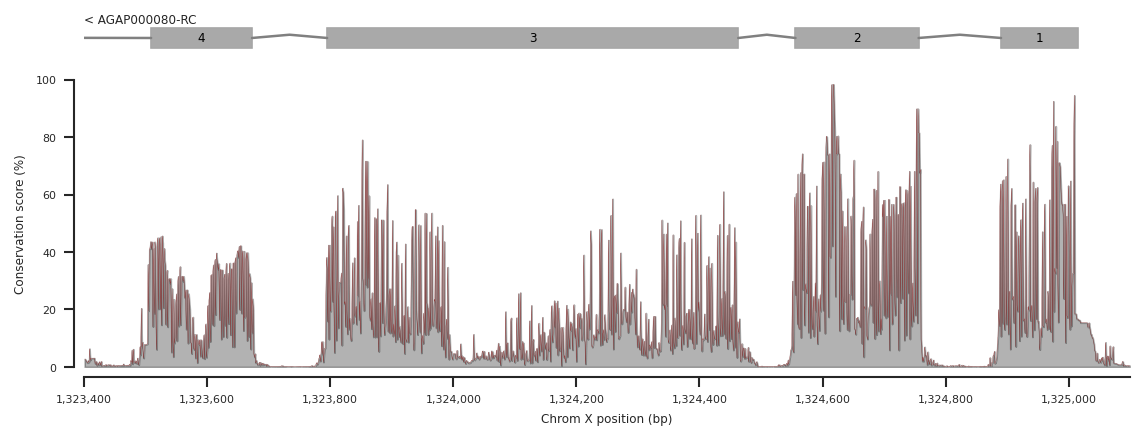

In [61]:
## conservation score in BTB region 
Cs_fig(data=fru_RC, xlim=('X', 1323400, 1325100))